____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + G (T_e - T_i),
\end{align}
$$

which assumes a cylindrical plasma composed of electrons and ions with no mass flow. 

Main areas where major improvements are needed:
1. Plasma Formulary version of parameters
2. Allow density variation 
3. Nicer visualizations, including animations, would be nice to have in the long run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from physics import JT_GMS_Physics, SMT
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from TTM import Cylindrical_Grid, Experiment, TwoTemperatureModel


In [2]:
grid  = Cylindrical_Grid(200e-6) 
Zstar, A = 1, 40
Te_initial, Ti_initial = 18000, 10300 #[K]
laser_width = 50e-6 # [m]
n0 = 6.3e26
# Create Experimental layout and TTM solver
Argon_jt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Argon', model = "JT")
ttm_jt = TwoTemperatureModel(Argon_jt, model = "JT")
Argon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Argon', model = "SMT")
ttm_smt = TwoTemperatureModel(Argon_smt, model = "SMT")

In [3]:
print(Argon_jt.params.electron_thermal_conductivity(n0, n0, Argon_smt.m_i, Argon_smt.Z_i, Te_initial, Ti_initial))
print(Argon_smt.params.electron_thermal_conductivity(n0, n0, Argon_smt.m_i, Argon_smt.Z_i, Te_initial, Ti_initial))

214372.02342858497
45.09712022062085


In [4]:
print("JT Model")
ttm_jt.make_times()
ttm_jt.print_timescales()

print("\nSMT Model")
ttm_smt.make_times()
ttm_smt.print_timescales()

JT Model

Default simulation time: 9.0e-01 ns,  dt = 2.4e-02 ps
  Diffusion time (r_max): e:2.4e+00 ns, i:5.2e+45 ns 
  Diffusion time (dr): e:2.4e-04 ns, i:5.2e+41 ns 
  Thermalization Times: 2e+02 ps  2e+02 ps

SMT Model

Default simulation time: 1.1e+00 ns,  dt = 2.2e+01 ps
  Diffusion time (r_max): e:1.2e+04 ns, i:5.2e+45 ns 
  Diffusion time (dr): e:1.2e+00 ns, i:5.2e+41 ns 
  Thermalization Times: 2e+02 ps  2e+02 ps


In [5]:
ttm_jt.solve_TTM(tmax=4.5e-9)
ttm_smt.solve_TTM(tmax=4.5e-9)

In [6]:
def plot_temp_profiles(ttm, grid, plot_times = None, ax = None):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_list)*0.99,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm_jt.t_list[ti]
        ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
        ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    # ax.set_ylim(0,10.1)
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)


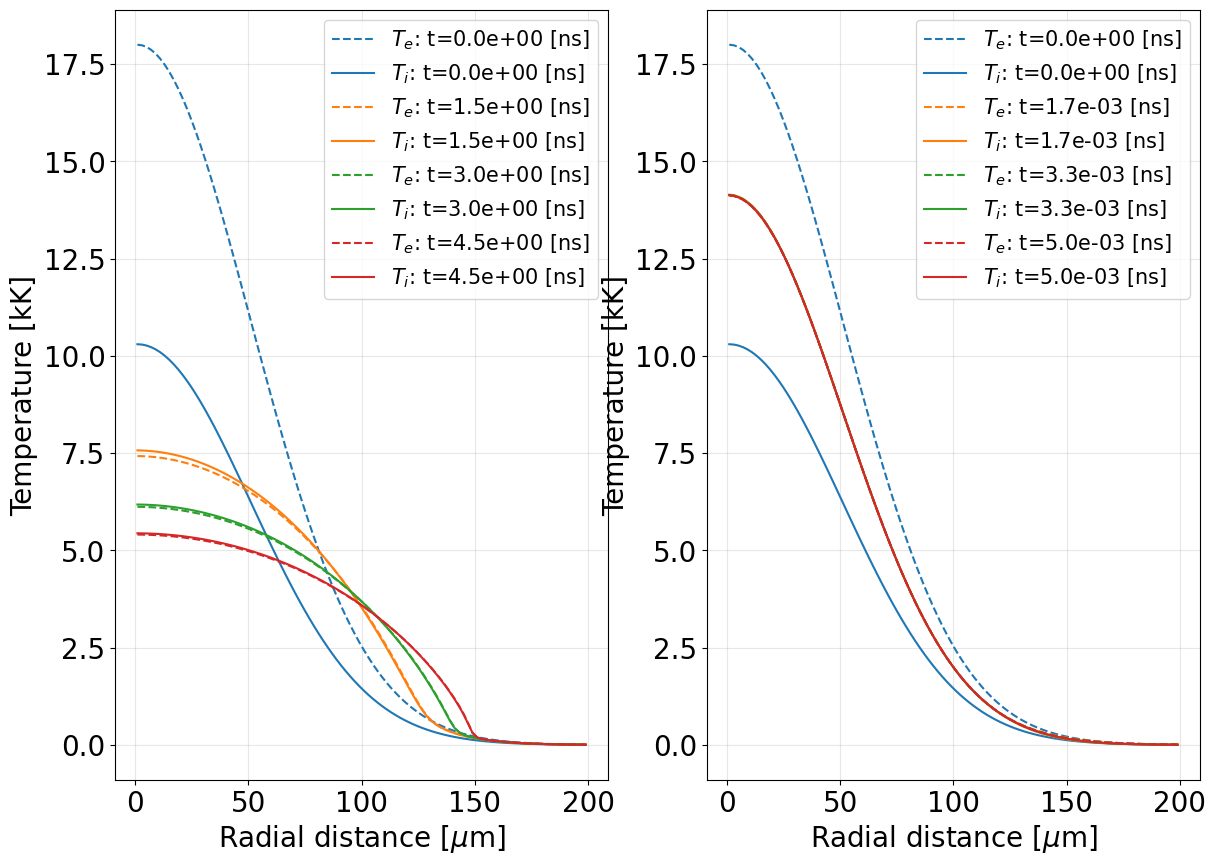

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,10),facecolor='w')

plot_temp_profiles(ttm_jt, grid, ax = ax[0])
plot_temp_profiles(ttm_smt, grid, ax = ax[1])


In [8]:
def plot_temp_evolution(ttm, ax):

    ti_1, ti_2 = -20000, -1
    ti_1, ti_2 = -100, -1
    T_av_1 = (ttm.Ti_list[ti_1][0] + ttm.Te_list[ti_1][0] )/2
    T_av_2 = (ttm.Ti_list[ti_2][0] + ttm.Te_list[ti_2][0] )/2
    dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])
    T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))

    T_av = 0.5*(np.array(ttm.Te_list) + np.array(ttm.Ti_list))

    ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Te_list).T[0]*1e-3,label=r"$T_e$ (origin)")
    ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Ti_list).T[0]*1e-3,label=r"$T_i$ (origin)")
    ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k')#,label='Diffusion Estimate: dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9))
    ax.plot(np.array(ttm.t_list)*1e9, T_av[:,0]*1e-3,'--k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0,0]*1e-3))

#     ax.annotate(r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12), xy=(0.1, 0.6), xycoords='figure fraction',
#                 xytext=(0.3, .8), textcoords='axes fraction',
#                 va='top', ha='left',fontsize=20,
#                 arrowprops=dict(facecolor='black', shrink=0.02))

#     ax.annotate('Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9), xy=(0.5, 0.2), xycoords='figure fraction',
#                 xytext=(0.5, .4), textcoords='axes fraction',
#                 va='top', ha='left',fontsize=20,
#                 arrowprops=dict(facecolor='black', shrink=0.02))

    # Plot settings
#     ax.set_xlabel(r"Time (ns)", fontsize=20)
#     ax.set_ylabel("Temperature [kK]",fontsize=20)
#     ax.tick_params(labelsize=20)
#     ax.set_xlim(0,ttm_jt.tmax*1e9)

#     ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
#     ax.legend(fontsize=17)
#     plt.show()

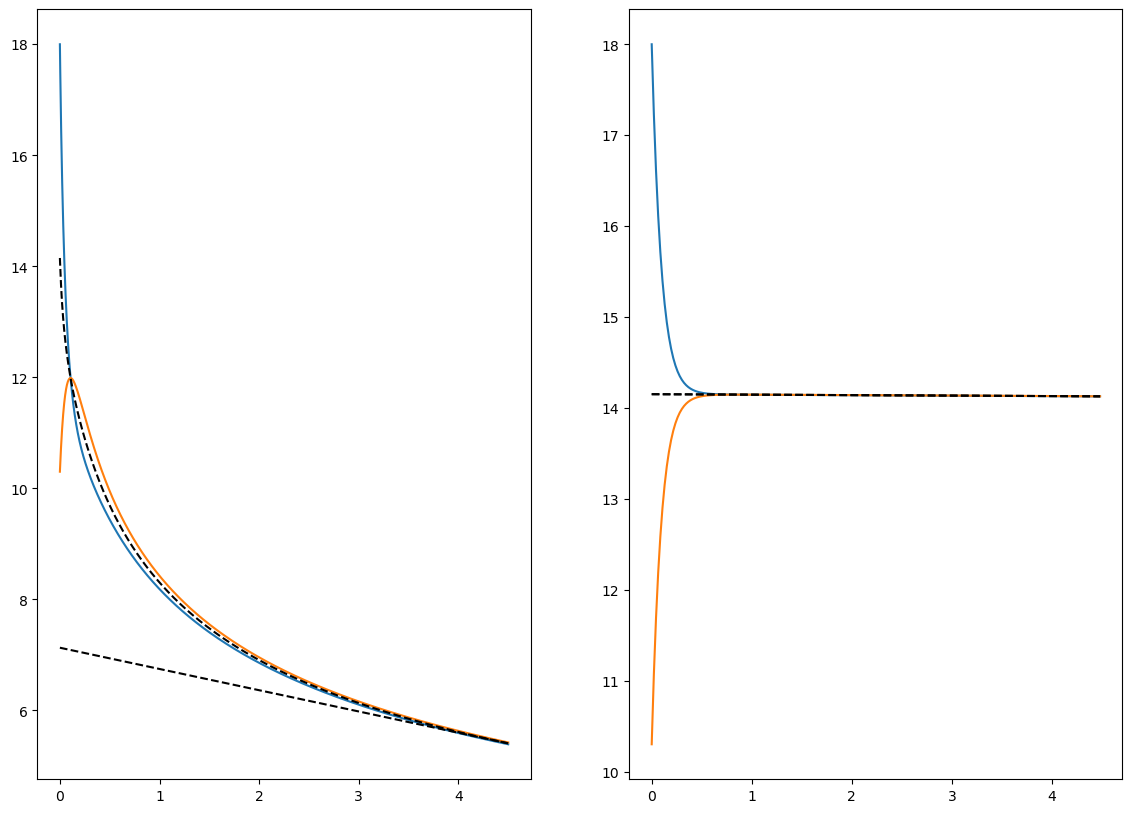

In [9]:
fig, ax = plt.subplots(1,2,figsize=(14,10),facecolor='w')

plot_temp_evolution(ttm_jt, ax[0])
plot_temp_evolution(ttm_smt, ax[1])